In [1]:
!pip install nibabel
!pip install nilearn
!pip install pydicom
!pip install tensorboardX
!pip install tqdm

    100% |████████████████████████████████| 3.3MB 9.5MB/s eta 0:00:01
    100% |████████████████████████████████| 2.4MB 14.5MB/s ta 0:00:01
    100% |████████████████████████████████| 7.0MB 5.3MB/s eta 0:00:01
    100% |████████████████████████████████| 245kB 12.4MB/s ta 0:00:01


In [1]:
#General imports
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pydicom
# from pydicom.data import get_testdata_files
# from pydicom.filereader import read_dicomdir
from subprocess import call
import sys
import xml.etree.ElementTree as ET

#Pytorch imports
import torch
from torch import nn
from torch import optim
from torch.optim import lr_scheduler

#Local imports
from utils import Logger,load_old_model
from train import train_epoch
from validation import val_epoch
from nvnet import MiniNvNet, NvNet
from metrics import CombinedLoss, SoftDiceLoss
from dataset import BratsDataset, StanfordDataset, StanfordSmallDataset

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
#When there's 2 GPUs
#os.environ["CUDA_VISIBLE_DEVICES"]="1,0"

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"

torch.cuda.empty_cache()
print('__Python VERSION:', sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('__CUDA VERSION')

# call(["nvcc", "--version"]) does not work
! nvcc --version
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')
call(["nvidia-smi", "--format=csv", "--query-gpu=index,name,driver_version,memory.total,memory.used,memory.free"])
print('Active CUDA Device: GPU', torch.cuda.current_device())

print ('Available devices ', torch.cuda.device_count())
print ('Current cuda device ', torch.cuda.current_device())

__Python VERSION: 3.7.3 (default, Mar 27 2019, 22:11:17) 
[GCC 7.3.0]
__pyTorch VERSION: 1.1.0
__CUDA VERSION
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130
__CUDNN VERSION: 7501
__Number CUDA Devices: 1
__Devices
Active CUDA Device: GPU 0
Available devices  1
Current cuda device  0


In [3]:
DATASET_GLOBAL_MEAN = 321.56370587244527
DATASET_GLOBAL_STDDEV = 517.4083720223107

DATASET_SAG_MEAN = 319.38926782103283
DATASET_SAG_STDDEV = 447.42789129337154

config = dict()
config["cuda_devices"] = None
# config["labels"] = (1, 2, 4)
config["labels"] = (1,) # change label to train
config["model_file"] = os.path.abspath("single_label_{}_dice.h5".format(config["labels"][0]))
config["initial_learning_rate"] = 1e-4
config["batch_size"] = 2
config["validation_batch_size"] = 2
config["image_shape"] = (128, 128, 128)
# config["image_shape"] = (160, 512, 512)
# config["image_shape"] = (160, 256, 256)
config["activation"] = "relu"
config["normalizaiton"] = "group_normalization"
config["mode"] = "trilinear"
config["n_labels"] = len(config["labels"])
#config["all_modalities"] = ["t1", "t1ce", "flair", "t2"]
config["all_modalities"] = ["bilat"]#["t1", "sag"]
config["training_modalities"] = config["all_modalities"]  # change this if you want to only use some of the modalities
config["nb_channels"] = len(config["training_modalities"])
config["input_shape"] = tuple([config["batch_size"]] + [config["nb_channels"]] + list(config["image_shape"]))
config["loss_k1_weight"] = 0.1
config["loss_k2_weight"] = 0.1
config["random_offset"] = False # Boolean. Augments the data by randomly move an axis during generating a data
config["random_flip"] = False  # Boolean. Augments the data by randomly flipping an axis during generating a data
# config["permute"] = True  # data shape must be a cube. Augments the data by permuting in various directions
config["random_crop"] = False  # Boolean. Augments the data by randomly cropping in depth dimension
config["random_intensity_shift"] = False  # Boolean. Augments the data by randomly shifting and scaling pixel values
config["result_path"] = "./checkpoint_models/"
config["data_file"] = os.path.abspath("isensee_mixed_brats_data.h5")
# config["training_file"] = os.path.abspath("isensee_mixed_training_ids.pkl")
# config["validation_file"] = os.path.abspath("isensee_mixed_validation_ids.pkl")
# config["test_file"] = os.path.abspath("isensee_mixed_validation_ids.pkl")
config["training_dir"] = "data/preprocessed/sag/train"
config["validation_dir"] = "data/preprocessed/sag/val"
config["test_dir"] = "data/preprocessed/sag/test"
config["saved_model_file"] = None#"checkpoint_models/single_label_1_dice/best_model_file.pth" #None
config["overwrite"] = False  # If True, will create new files. If False, will use previously written files.
config["L2_norm"] = 1e-5
config["patience"] = 2
config["lr_decay"] = 0.7
config["epochs"] = 300
config["checkpoint"] = True  # Boolean. If True, will save the best model as checkpoint.
config["label_containing"] = True  # Boolean. If True, will generate label with overlapping.
config["VAE_enable"] = True  # Boolean. If True, will enable the VAE module.

In [4]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
    config["cuda_devices"] = True
else:
    device = torch.device('cpu')
    config["cuda_devices"] = None

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

using device: cuda


In [5]:
def loadDCM(directory, sort = False):
    dataset = []

    for file in os.listdir(os.fsencode(directory)):
        filename = os.fsdecode(file)
        if filename.endswith(".dcm"):
            data = pydicom.read_file(os.path.join(directory, filename))
            #data = pydicom.dcmread(os.path.join(directory, filename))
            dataset.append(data)
    
    if sort:
        dataset = sorted(dataset, key=lambda x: x.SliceLocation, reverse=True)
            
    return dataset

def loadAIM(directory):
    trees = []

    for file in os.listdir(os.fsencode(directory)):
        filename = os.fsdecode(file)
        if filename.endswith(".xml"): 
            tree = ET.parse(os.path.join(directory, filename))
            trees.append(tree)
            
    return trees

def displayDCMInfo(dataset, start = 0, end = -1, verbose = False):
    
    if verbose:
        for i in range(start, end):
            print(dataset[i])
            print()
    else:
        #Print common attributes once
        with dataset[0] as data:
            print("Patient id..............:", data.PatientID)
            print("Modality................:", data.Modality)
            print("Study Description.......:", data.StudyDescription)
            print("Study Date..............:", data.StudyDate)
            print("Series Description......:", data.SeriesDescription)
            print("Series Instance UID.....:", data.SeriesInstanceUID)
            print("Frame of Reference UID..:", data.FrameOfReferenceUID)
            if 'PixelData' in data:
                rows = int(data.Rows)
                cols = int(data.Columns)
                print("Image size.......: {rows:d} x {cols:d}, {size:d} bytes".format(
                    rows=rows, cols=cols, size=len(data.PixelData)))
                if 'PixelSpacing' in data:
                    print("Pixel spacing....:", data.PixelSpacing)
            print()
        
        for i in range(start, end):
            data = dataset[i]
            print("SOP Instance UID........:", data.SOPInstanceUID)
            if 'SliceLocation' in dataset[i]:
                print("Image Position.....:", data.ImagePositionPatient)
                print("Image Orientation..:", data.ImageOrientationPatient)
                print("Slice Location.....:", data.SliceLocation)
            print()

        

#Load data
patient_dir = 'data/one patient/Study-9999.101939720942871275324509427196570098954/'
#series_dir = 'Series-9999.112219730827615999359378565869345885699/' #AXIAL T1
#series_dir = 'Series-9999.137535717376898792051727127824821105315' #3-axis localizer
#series_dir = 'Series-9999.145269246654496964264400862264317579558' #SAG T2 FSE FS
series_dir = 'Series-9999.223348084479508628353575114983913714125/' #Bilat 3DSSMT POST
directory = patient_dir + series_dir

dataset = loadDCM(directory, sort = True)
annotations = loadAIM(directory)
            
print("Num of DCM images loaded:", len(dataset), end='\n\n')
print("Num of AIMs loaded:", len(annotations), end='\n\n')

#Display metadata of the first 5 frames
#displayDCMInfo(dataset, start=0, end=5, verbose=False)
displayDCMInfo(dataset, start=115, end=116, verbose=False)


#Load labels

# label_directory = 'data/annotations/103/'
label_directory = 'data/sample/'

label_dataset = loadDCM(label_directory)

print("Dim of SEG label:", label_dataset[0].pixel_array.shape, end='\n\n')

# #Display metadata of the label frames
# displayDCMInfo(label_dataset, start=1, end=2, verbose=True)


FileNotFoundError: [Errno 2] No such file or directory: b'data/one patient/Study-9999.101939720942871275324509427196570098954/Series-9999.223348084479508628353575114983913714125/'

In [ ]:

#Extract 3D Pixel Array
def extractPixelMatrix(dataset):
    pixels = list(map(lambda data: data.pixel_array, dataset))
    return np.array(pixels)

dataset_pixels = extractPixelMatrix(dataset)
label_dataset_pixels = extractPixelMatrix(label_dataset)

#construct full label matrix
_, H, W = label_dataset_pixels[0].shape
label_dataset_pixels = np.vstack([np.zeros((106, H, W)), label_dataset_pixels[0,::-1], np.zeros((150-106-19, H, W))])

#add one more dim for modality
dataset_pixels = dataset_pixels[np.newaxis, :, :, :]
label_dataset_pixels = label_dataset_pixels[np.newaxis, :, :, :]

print("3D image dimension:", dataset_pixels.shape)
print("3D mask dimension:", label_dataset_pixels.shape)


In [6]:
#Use Stanford Dataset
training_data = StanfordDataset(phase="train", config=config)
training_data.file_open()

print("Loaded ", len(training_data), " training data")

for i in range(len(training_data)):
    input_data, label_data = training_data[i]  
    print("Input shape:", input_data.shape)
    print("Label shape:", label_data.shape)
    print("Tumor volume:", np.sum(label_data[0,:,:,:]))
    print("Frames with tumor:", sum([1 if np.sum(label_data[0,i,:,:]) > 0 else 0 for i in range(label_data.shape[1])]))
    
validation_data = StanfordDataset(phase="validate", config=config)
validation_data.file_open()

print("Loaded ", len(validation_data), " validation data")

for i in range(len(validation_data)):
    input_data, label_data = validation_data[i]  
    print("Input shape:", input_data.shape)
    print("Label shape:", label_data.shape)
    print("Tumor volume:", np.sum(label_data[0,:,:,:]))
    print("Frames with tumor:", sum([1 if np.sum(label_data[0,i,:,:]) > 0 else 0 for i in range(label_data.shape[1])]))

Loaded  60  training data
Tumor frames: 26 / 156
Input shape: (1, 128, 128, 128)
Label shape: (2, 128, 128, 128)
Tumor volume: 17092.0
Frames with tumor: 104
Tumor frames: 8 / 162
Input shape: (1, 128, 128, 128)
Label shape: (2, 128, 128, 128)
Tumor volume: 1220.0
Frames with tumor: 32
Tumor frames: 11 / 150
Input shape: (1, 128, 128, 128)
Label shape: (2, 128, 128, 128)
Tumor volume: 5800.0
Frames with tumor: 44
Tumor frames: 9 / 154
Input shape: (1, 128, 128, 128)
Label shape: (2, 128, 128, 128)
Tumor volume: 1532.0
Frames with tumor: 36
Tumor frames: 9 / 144
Input shape: (1, 128, 128, 128)
Label shape: (2, 128, 128, 128)
Tumor volume: 1776.0
Frames with tumor: 36
Tumor frames: 20 / 150
Input shape: (1, 128, 128, 128)
Label shape: (2, 128, 128, 128)
Tumor volume: 37900.0
Frames with tumor: 80
Input shape: (1, 128, 128, 128)
Label shape: (2, 128, 128, 128)
Tumor volume: 1066.0
Frames with tumor: 27
Tumor frames: 17 / 152
Input shape: (1, 128, 128, 128)
Label shape: (2, 128, 128, 128)


Input shape: (1, 128, 128, 128)
Label shape: (2, 128, 128, 128)
Tumor volume: 1428.0
Frames with tumor: 36


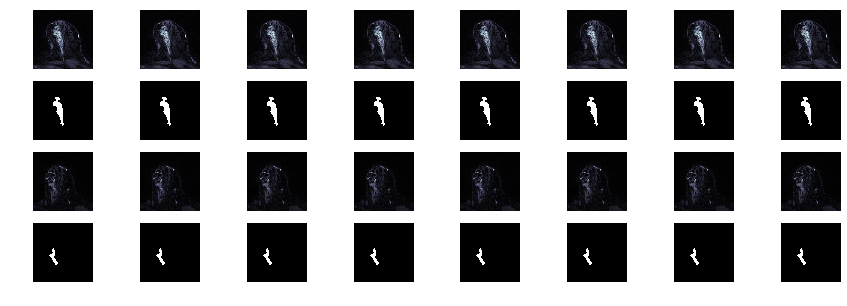

In [8]:
#Visualize data

def imshow_no_ax(img, normalize=True):
    """ Tiny helper to show images as uint8 and remove axis labels """
    if normalize:
        img_max, img_min = np.max(img), np.min(img)
        img = 255.0 * (img - img_min) / (img_max - img_min)
    plt.imshow(img, cmap=plt.cm.bone)
    #plt.imshow(img.astype('uint8'))
    plt.gca().axis('off') 

#Display single image
plt.figure(figsize=(15,5))
# imshow_no_ax(input_data[0][116], normalize=False)

#Display many of the same frame (to show data augmentation)
for i in range(8):
    input_data, label_data = validation_data[1]
    plt.subplot(4, 8, i+1)
    imshow_no_ax(input_data[0,30,:,:], normalize=False)
    plt.subplot(4, 8, i+9)
    imshow_no_ax(label_data[0,30,:,:], normalize=False)
    plt.subplot(4, 8, i+17)
    imshow_no_ax(input_data[0,106,:,:], normalize=False)
    plt.subplot(4, 8, i+25)
    imshow_no_ax(label_data[0,106,:,:], normalize=False)

plt.show()

# #Display multiple images
# for i in range(20):
#     plt.subplot(4, 5, i+1)
#     imshow_no_ax(input_data[0][106:126][i], normalize=False)

# plt.show()    

# #Display masks
# for i in range(19):
#     plt.subplot(4, 5, i+1)
#     imshow_no_ax(label_data[0][106 + i, :, :], normalize=False)

In [ ]:
def main():
    # init or load model
    print("init model with input shape",config["input_shape"])
    model = NvNet(config=config)
    #model = MiniNvNet(config=config)
    parameters = model.parameters()
    optimizer = optim.Adam(parameters, 
                           lr=config["initial_learning_rate"],
                           weight_decay = config["L2_norm"])
    start_epoch = 1
    if config["VAE_enable"]:
        loss_function = CombinedLoss(k1=config["loss_k1_weight"], k2=config["loss_k2_weight"])
    else:
        loss_function = SoftDiceLoss()
    # data_generator
    print("data generating")
    training_data = StanfordDataset(phase="train", config=config)
    validation_data = StanfordDataset(phase="validate", config=config)

    train_logger = Logger(model_name=config["model_file"],header=['epoch', 'loss', 'acc', 'lr'])

    if config["cuda_devices"] is not None:
        gpu_list = list(range(0, 2))
        model = nn.DataParallel(model, gpu_list)  # multi-gpu training
        model = model.cuda()
        loss_function = loss_function.cuda() 
#         model = model.to(device=device)  # move the model parameters to CPU/GPU
#         loss_function = loss_function.to(device=device)
        
    if not config["overwrite"] and config["saved_model_file"] is not None:
        if not os.path.exists(config["saved_model_file"]):
            raise Exception("Invalid model path!")
        model, start_epoch, optimizer = load_old_model(model, optimizer, saved_model_path=config["saved_model_file"])    
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=config["lr_decay"],patience=config["patience"])
    
    print("training on label:{}".format(config["labels"]))
    max_val_acc = 0.
    for i in range(start_epoch,config["epochs"]):
        train_epoch(epoch=i, 
                    data_set=training_data, 
                    model=model,
                    criterion=loss_function, 
                    optimizer=optimizer, 
                    opt=config, 
                    logger=train_logger) 
        
        val_loss, val_acc = val_epoch(epoch=i, 
                  data_set=validation_data, 
                  model=model, 
                  criterion=loss_function, 
                  opt=config,
                  optimizer=optimizer, 
                  logger=train_logger)
        scheduler.step(val_loss)
        if config["checkpoint"] and val_acc > max_val_acc:
            max_val_acc = val_acc
            save_dir = os.path.join(config["result_path"], config["model_file"].split("/")[-1].split(".h5")[0])
            if not os.path.exists(save_dir):
                os.makedirs(save_dir)
            save_states_path = os.path.join(save_dir,'epoch_{0}_val_loss_{1:.4f}_acc_{2:.4f}.pth'.format(i, val_loss, val_acc))
            states = {
                'epoch': i + 1,
                'state_dict': model.state_dict(),
                'optimizer': optimizer.state_dict(),
            }
            torch.save(states, save_states_path)
            save_model_path = os.path.join(save_dir, "best_model_file.pth")
            if os.path.exists(save_model_path):
                os.system("rm "+save_model_path)
            torch.save(model, save_model_path)

In [ ]:
main()

In [ ]:
#Testing
from nvnet import *

torch.cuda.empty_cache()

model = MiniNvNet(config=config)

# gpu_list = list(range(0, 2))

model = model.cuda()
# model = nn.DataParallel(model, gpu_list).cuda()

parameters = model.parameters()
optimizer = optim.Adam(parameters, 
                           lr=config["initial_learning_rate"],
                           weight_decay = config["L2_norm"])
start_epoch = 1
if config["VAE_enable"]:
    loss_function = CombinedLoss(k1=config["loss_k1_weight"], k2=config["loss_k2_weight"])
else:
    loss_function = SoftDiceLoss()

training_data = StanfordDataset(phase="train", config=config)

training_data.file_open()

train_loader = torch.utils.data.DataLoader(dataset=training_data, 
                                               batch_size=1, 
                                               shuffle=True, 
                                               pin_memory=True)


from utils import AverageMeter, calculate_accuracy


losses = AverageMeter()
accuracies = AverageMeter()


In [ ]:
for i, (inputs, targets) in enumerate(train_loader):
    
    inputs = inputs.type(torch.FloatTensor)
    inputs = inputs.cuda()
    #inputs.to(device=device, dtype=dtype)
    targets = targets.type(torch.FloatTensor)
    targets = targets.cuda()
    #targets.to(device=device, dtype=dtype)
    print(i, inputs.size(), targets.size())
    if config["VAE_enable"]:
        outputs, distr = model(inputs)
        loss = loss_function(outputs, targets, distr)
    else:
        outputs = model(inputs)
        loss = loss_function(outputs, targets)
    acc = calculate_accuracy(outputs.cpu(), targets.cpu())
    losses.update(loss.cpu(), inputs.size(0))
    accuracies.update(acc, inputs.size(0))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


In [7]:
from tqdm import tqdm
from utils import calculate_accuracy

#Validate
model = NvNet(config=config)
parameters = model.parameters()
optimizer = optim.Adam(parameters, 
                       lr=config["initial_learning_rate"],
                       weight_decay = config["L2_norm"])

if config["VAE_enable"]:
    loss_function = CombinedLoss(k1=config["loss_k1_weight"], k2=config["loss_k2_weight"])
else:
    loss_function = SoftDiceLoss()
    
# data_generator
print("data generating...")
#data_set = StanfordDataset(phase="train", config=config)
data_set = StanfordDataset(phase="validate", config=config)


if config["cuda_devices"] is not None:
    model = model.cuda()
    loss_function = loss_function.cuda()
    
#model, _, optimizer = load_old_model(model, optimizer, saved_model_path=config["saved_model_file"])    
    
model.eval()


data_set.file_open()
validation_loader = torch.utils.data.DataLoader(dataset=data_set,
                                 batch_size=1, 
                                 shuffle=False,
                                 pin_memory=True)
val_process = tqdm(validation_loader)

print("data generated!")

for i, (inputs, targets) in enumerate(val_process):
    
    if config["cuda_devices"] is not None:
        inputs = inputs.type(torch.FloatTensor)
        inputs = inputs.cuda()
        targets = targets.type(torch.FloatTensor)
        targets = targets.cuda()
    with torch.no_grad():
        if config["VAE_enable"]:
            outputs, distr = model(inputs)
            loss = loss_function(outputs, targets, distr)
        else:
            outputs = model(inputs)
            loss = loss_function(outputs, targets)

    acc = calculate_accuracy(outputs.cpu(), targets.cpu())
    
    if i > 0:
        val_process.set_description("Loss: %.4f, Acc: %.4f"%(loss, acc))
    
    print("ID:", i)
    print("Loss:", loss.cpu().numpy())
    print("Acc:", acc.numpy())
    
    preds = outputs.cpu().numpy()
    truths = targets.cpu().numpy()
    pred = preds[0, 0, : , : , :]
    truth = truths[0, 0, : , : , :]
    
    print("Shape:", pred.shape, truth.shape)
    print("Tumor vol:", np.sum(pred[:,:,:]), np.sum(truth[:,:,:]))
    print("Max:", np.max(pred), np.max(truth))
    print("Min:", np.min(pred), np.min(truth))
    print("Mean:", np.mean(pred), np.mean(truth))
    print("StdDev:", np.std(pred), np.std(truth))
    print("# frames with 1:", sum([1 if np.sum(pred[i,:,:]) > 0 else 0 for i in range(pred.shape[0])]), sum([1 if np.sum(truth[i,:,:]) > 0 else 0 for i in range(truth.shape[0])]))


data_set.file_close()


data generating...


  0%|          | 0/8 [00:00<?, ?it/s]

data generated!


 12%|█▎        | 1/8 [01:58<13:48, 118.36s/it]

ID: 0
Loss: 1.4696561
Acc: 2.5953947e-05
Shape: (128, 128, 128) (128, 128, 128)
Tumor vol: 1083934.5 2480.0
Max: 0.84616745 1.0
Min: 0.02785566 0.0
Mean: 0.51686025 0.0011825562
StdDev: 0.07806211 0.03436798
# frames with 1: 128 36


Loss: 1.6135, Acc: 0.0000:  25%|██▌       | 2/8 [03:50<11:39, 116.64s/it]

ID: 1
Loss: 1.6135447
Acc: 2.2954312e-06
Shape: (128, 128, 128) (128, 128, 128)
Tumor vol: 1087166.0 36.0
Max: 0.77038467 1.0
Min: 0.04481996 0.0
Mean: 0.51840115 1.7166138e-05
StdDev: 0.091021344 0.004143169
# frames with 1: 128 16


Loss: 1.3757, Acc: 0.0000:  38%|███▊      | 3/8 [05:42<09:35, 115.01s/it]

ID: 2
Loss: 1.3757256
Acc: 4.379748e-05
Shape: (128, 128, 128) (128, 128, 128)
Tumor vol: 1070812.4 2160.0
Max: 0.7960327 1.0
Min: 0.007657638 0.0
Mean: 0.51060313 0.0010299683
StdDev: 0.05471467 0.032076586
# frames with 1: 128 40


Loss: 1.5227, Acc: 0.0001:  50%|█████     | 4/8 [07:33<07:35, 113.97s/it]

ID: 3
Loss: 1.5227168
Acc: 8.636016e-05
Shape: (128, 128, 128) (128, 128, 128)
Tumor vol: 1097065.4 5496.0
Max: 0.96534437 1.0
Min: 0.0043540644 0.0
Mean: 0.52312154 0.002620697
StdDev: 0.07846059 0.051125593
# frames with 1: 128 74


Loss: 1.3979, Acc: 0.0000:  62%|██████▎   | 5/8 [09:25<05:39, 113.17s/it]

ID: 4
Loss: 1.3979161
Acc: 1.2732056e-05
Shape: (128, 128, 128) (128, 128, 128)
Tumor vol: 1094437.4 3260.0
Max: 0.79464126 1.0
Min: 0.010542294 0.0
Mean: 0.5218684 0.0015544891
StdDev: 0.07055021 0.03939635
# frames with 1: 128 48


Loss: 1.4090, Acc: 0.0000:  75%|███████▌  | 6/8 [11:17<03:46, 113.06s/it]

ID: 5
Loss: 1.4089581
Acc: 1.5497075e-05
Shape: (128, 128, 128) (128, 128, 128)
Tumor vol: 1091680.5 1580.0
Max: 0.82401705 1.0
Min: 0.02400525 0.0
Mean: 0.5205538 0.0007534027
StdDev: 0.072008915 0.027437836
# frames with 1: 128 84


Loss: 1.3838, Acc: 0.0000:  88%|████████▊ | 7/8 [13:10<01:53, 113.02s/it]

ID: 6
Loss: 1.3837712
Acc: 3.3520732e-06
Shape: (128, 128, 128) (128, 128, 128)
Tumor vol: 1085868.4 5788.0
Max: 0.83413625 1.0
Min: 0.022390531 0.0
Mean: 0.5177824 0.0027599335
StdDev: 0.06245654 0.052462537
# frames with 1: 128 60


Loss: 1.4416, Acc: 0.0001: 100%|██████████| 8/8 [15:00<00:00, 112.15s/it]

ID: 7
Loss: 1.4416308
Acc: 0.00011794769
Shape: (128, 128, 128) (128, 128, 128)
Tumor vol: 1090273.8 7808.0
Max: 0.8612461 1.0
Min: 0.008813158 0.0
Mean: 0.51988304 0.0037231445
StdDev: 0.07750911 0.060903903
# frames with 1: 128 68


In [5]:
from tqdm import tqdm
from utils import calculate_accuracy

#Validate
model = NvNet(config=config)
parameters = model.parameters()
optimizer = optim.Adam(parameters, 
                       lr=config["initial_learning_rate"],
                       weight_decay = config["L2_norm"])

config["VAE_enable"] = True
if config["VAE_enable"]:
    loss_function = CombinedLoss(k1=config["loss_k1_weight"], k2=config["loss_k2_weight"])
else:
    loss_function = SoftDiceLoss()
    
# data_generator
print("data generating...")
# Loading from 2081616986
# (158, 512, 512)
# Loading from 1442055673
# (156, 512, 512)
# Loading from 3394827382
# (140, 512, 512)
# Loading from 8669051505
# (156, 512, 512)
# Loading from 3146743329
# (162, 512, 512)
# Loading from 1572850596
# (150, 512, 512)
# Loading from 1399990454
# (156, 512, 512)
# Loading from 7938108228
# (154, 512, 512)
# Loading from 3078009188
# (156, 512, 512)
# Loading from 2930604915
# (144, 512, 512)
data_set = StanfordSmallDataset(phase="train", config=config, limit=4)
#data_set = StanfordSmallDataset(phase="validate", config=config, limit=1)


if config["cuda_devices"] is not None:
    #gpu_list = list(range(0, 2))
    #model = nn.DataParallel(model, gpu_list) # multi-gpu training
    model = model.cuda()
    loss_function = loss_function.cuda()


#No VAE
#checkpoint = "checkpoint_models/single_label_1_dice_no_vae/best_model_file_50.pth"

#With VAE, higher loss coefficient (0.7)
#checkpoint = "checkpoint_models/single_label_1_dice/best_model_file_392.pth"
#checkpoint = "checkpoint_models/archived_vae_lr=1e-3_k1=0.7_k2=0.7/best_model_file_99.pth"
#checkpoint = "checkpoint_models/archived_vae_lr=1e-3_k1=0.3_k2=0.3/best_model_file_399.pth"
#checkpoint = "checkpoint_models/archived_vae_lr=1e-3_k1=0.2_k2=0.2/best_model_file_399.pth"
#checkpoint = "checkpoint_models/single_label_1_dice/best_model_file_25.pth"
#checkpoint = "checkpoint_models/archived_vae_lr=1e-3_k1=0.7_k2=0.1/best_model_file_99.pth"

#Regular
#checkpoint = "checkpoint_models/archived_vae_lr=1e-4_k1=0.2_k2=0.2_t=10_batch=1/best_model_file_41.pth"
#checkpoint = "checkpoint_models/archived_vae_lr=1e-4_k1=0.4_k2=0.4_t=10_batch=1/best_model_file_46.pth"
#checkpoint = "checkpoint_models/archived_vae_lr=1e-4_k1=0.1_k2=0.1_t=10_batch=1/best_model_file_39.pth"
#checkpoint = "checkpoint_models/archived_vae_lr=1e-3_k1=0.1_k2=0.1/best_model_file_399.pth"
#checkpoint = "checkpoint_models/single_label_1_dice/epoch_1_val_loss_2.3032_acc_0.0000.pth"
#checkpoint = "checkpoint_models/single_label_1_dice/epoch_4_val_loss_2.3821_acc_0.0000.pth"
# model, _, optimizer = load_old_model(model, optimizer, saved_model_path=checkpoint) 

#With Data Augmentation
#checkpoint = "checkpoint_models/archived_vae_lr=1e-4_k1=0.1_k2=0.1_t=5_batch=1_random-crop=1/best_model_file_49.pth"
checkpoint = "checkpoint_models/archived_vae_lr=1e-4_k1=0.1_k2=0.1_t=5_batch=1_random-crop=1_random-flip=1/best_model_file_49.pth"


if config["cuda_devices"] is not None:
    model = torch.load(checkpoint)
else:
    model = torch.load(checkpoint, map_location='cpu')
    
model.eval()


data_set.file_open()
validation_loader = torch.utils.data.DataLoader(dataset=data_set,
                                 batch_size=1, 
                                 shuffle=False,
                                 pin_memory=True)
val_process = tqdm(validation_loader)

print("data generated!")

threshold = 0.9
eps = 1e-8

preds_list = []
truths_list = []

for i, (inputs, targets) in enumerate(val_process):
    
    if config["cuda_devices"] is not None:
        inputs = inputs.type(torch.FloatTensor)
        inputs = inputs.cuda()
        targets = targets.type(torch.FloatTensor)
        targets = targets.cuda()
    with torch.no_grad():
        if config["VAE_enable"]:
            outputs, distr = model(inputs)
            loss = loss_function(outputs, targets, distr)
        else:
            outputs = model(inputs)
            loss = loss_function(outputs, targets)

    outputs = outputs.cpu()
    targets = targets.cpu()
    acc = calculate_accuracy(outputs, targets, threshold)
    
    y_pred = outputs[:,0,:,:,:]
    y_truth = targets[:,0,:,:,:]
    y_pred = y_pred > threshold
    y_pred = y_pred.type(torch.FloatTensor)
    intersection = torch.sum(torch.mul(y_pred, y_truth)) + eps/2
    union = torch.sum(y_pred) + torch.sum(y_truth) + eps
    dice = 2 * intersection / union 
    
    if i > 0:
        val_process.set_description("Loss: %.4f, Acc: %.4f"%(loss, acc))
    
    print("ID:", i)
    print("Loss:", loss.cpu().numpy())
    print("Acc:", acc.numpy())
    print("Intersection:", intersection.numpy())
    print("Union:", union.numpy())
    
    preds = outputs.cpu().numpy()
    truths = targets.cpu().numpy()
    pred = preds[0, 0, : , : , :]
    truth = truths[0, 0, : , : , :]
    
    print("Shape:", pred.shape, truth.shape)
    print("Tumor vol:", np.sum(pred[:,:,:]), np.sum(truth[:,:,:]))
    print("Max:", np.max(pred), np.max(truth))
    print("Min:", np.min(pred), np.min(truth))
    print("Mean:", np.mean(pred), np.mean(truth))
    print("StdDev:", np.std(pred), np.std(truth))
    print("# frames with 1:", sum([1 if np.sum(pred[i,:,:]) > 0 else 0 for i in range(pred.shape[0])]), sum([1 if np.sum(truth[i,:,:]) > 0 else 0 for i in range(truth.shape[0])]))

    preds_list.append(preds)
    truths_list.append(truths)

data_set.file_close()


data generating...
Loading from 2081616986
(158, 512, 512)
Loading from 1442055673
(156, 512, 512)
Loading from 3394827382
(140, 512, 512)
Loading from 8669051505
(156, 512, 512)


  0%|          | 0/4 [00:00<?, ?it/s]

data generated!


 25%|██▌       | 1/4 [00:00<00:02,  1.19it/s]

dice_loss:0.4602, L2_loss:0.5773, KL_div:0.0977, combined_loss:0.5277
ID: 0
Loss: 0.5277107
Acc: 0.56792873
Intersection: 765.0
Union: 2694.0
Shape: (128, 128, 128) (128, 128, 128)
Tumor vol: 5873.747 1255.0
Max: 0.9998671 1.0
Min: 9.268462e-12 0.0
Mean: 0.0028008209 0.00059843063
StdDev: 0.0357047 0.024455514
# frames with 1: 128 11


Loss: 0.3508, Acc: 0.8186:  50%|█████     | 2/4 [00:01<00:01,  1.31it/s]

dice_loss:0.1809, L2_loss:1.5576, KL_div:0.1411, combined_loss:0.3508
ID: 1
Loss: 0.3507999
Acc: 0.81862986
Intersection: 1661.0
Union: 4058.0
Shape: (128, 128, 128) (128, 128, 128)
Tumor vol: 5086.5923 2118.0
Max: 0.99955374 1.0
Min: 2.6374376e-09 0.0
Mean: 0.0024254762 0.0010099411
StdDev: 0.035405178 0.031763494
# frames with 1: 128 37


Loss: 0.2827, Acc: 0.8631:  75%|███████▌  | 3/4 [00:01<00:00,  1.42it/s]

dice_loss:0.2224, L2_loss:0.5095, KL_div:0.0941, combined_loss:0.2827
ID: 2
Loss: 0.2827432
Acc: 0.8630769
Intersection: 561.0
Union: 1300.0
Shape: (128, 128, 128) (128, 128, 128)
Tumor vol: 2803.5408 670.0
Max: 0.99964464 1.0
Min: 2.6376137e-09 0.0
Mean: 0.0013368324 0.0003194809
StdDev: 0.021302182 0.017871223
# frames with 1: 128 9


Loss: 0.3505, Acc: 0.6405: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s]

dice_loss:0.2676, L2_loss:0.7715, KL_div:0.0577, combined_loss:0.3505
ID: 3
Loss: 0.3505081
Acc: 0.640471
Intersection: 2339.0
Union: 7304.0
Shape: (128, 128, 128) (128, 128, 128)
Tumor vol: 9106.778 4273.0
Max: 0.999943 1.0
Min: 1.4776388e-12 0.0
Mean: 0.0043424503 0.0020375252
StdDev: 0.047485713 0.045093067
# frames with 1: 128 26


(1, 2, 128, 128, 128) (1, 2, 128, 128, 128)
Shape: (10, 128, 128) (10, 128, 128)
Tumor vol: 2082 1247.0
Max: 0.9998671 1.0
Min: 1.0734545e-05 0.0
Mean: 0.016011842 0.007611084
StdDev: 0.09971946 0.08690889
Intersection: 1062.2244
Union: 2918.22509766625
Dice Loss: 0.2720065589978975


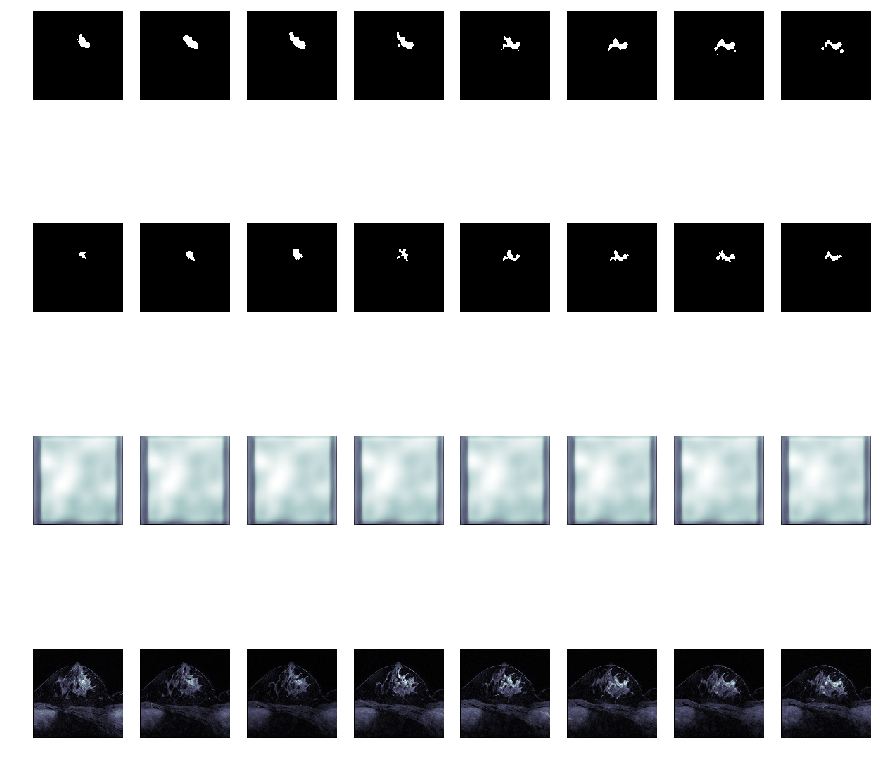

In [10]:
preds = preds_list[0]
truths = truths_list[0]
print(preds.shape, truths.shape)

start = 20 #110
end = 30#128
#0 tumor before 84, loss=1
#pred, truth = preds[0,0,84:,:,:], truths[0,0,84:,:,:]
#pred, truth = preds[0,0,110:,:,:], truths[0,0,110:,:,:]
#pred, truth = preds[0,0,:,:,:], truths[0,0,:,:,:]
pred, truth = preds[0,0,start:end,:,:], truths[0,0,start:end,:,:]
vae_pred, vae_truth = preds[0,1,start:end,:,:], truths[0,1,start:end,:,:]

#De-norm
vae_pred = vae_pred * DATASET_SAG_STD + DATASET_SAG_MEAN
vae_truth = vae_truth * DATASET_SAG_STD + DATASET_SAG_MEAN

print("Shape:", pred.shape, truth.shape)
print("Tumor vol:", np.sum(np.where(pred > 0.5, 1, 0)), np.sum(truth))
#print("Tumor vol:", np.sum(pred), np.sum(truth))
print("Max:", np.max(pred), np.max(truth))
print("Min:", np.min(pred), np.min(truth))
print("Mean:", np.mean(pred), np.mean(truth))
print("StdDev:", np.std(pred), np.std(truth))

intersection = np.sum(pred * truth)
union = np.sum(pred ** 2) + np.sum(truth ** 2) + eps
dice = 2 * intersection / union
dice_loss = 1 - dice

print("Intersection:", intersection)
print("Union:", union)
print("Dice Loss:", dice_loss)
#print("# frames with 1:", sum([1 if np.sum(pred[i,:,:]) > 0 else 0 for i in range(pred.shape[0])]), sum([1 if np.sum(truth[i,:,:]) > 0 else 0 for i in range(truth.shape[0])]))


#pred[0,10:20,10:20]=0.0
#s = pred[0,30:40,50:80]
#print(s)
#print(np.where(s > 0.5, 1., 0.))
#print(truth)


def imshow_no_ax(img, normalize=True):
    """ Tiny helper to show images as uint8 and remove axis labels """
    if normalize:
        img_max, img_min = np.max(img), np.min(img)
        img = 255.0 * (img - img_min) / (img_max - img_min)
    plt.imshow(img, cmap=plt.cm.bone)
    #plt.imshow(img.astype('uint8'))
    plt.gca().axis('off') 

#Display multiple images
N, _, _ = pred.shape
N=8
plt.figure(figsize=(15,15))

for i in range(N):
    plt.subplot(4, N, i+1)    
    imshow_no_ax(np.where(pred[i,:,:] > 0.5, 1., 0.), normalize=False)
    #imshow_no_ax(pred[i,:,:], normalize=False)
    plt.subplot(4, N, i+N+1)
    imshow_no_ax(truth[i,:,:], normalize=False)
    plt.subplot(4, N, i+2*N+1)    
    imshow_no_ax(vae_pred[i,:,:], normalize=False)
    plt.subplot(4, N, i+3*N+1)
    imshow_no_ax(vae_truth[i,:,:], normalize=False)
plt.show()

#### 

(512, 512, 156)


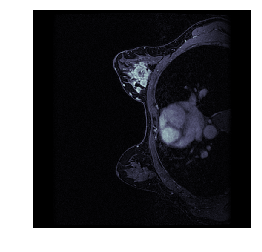

In [14]:
import nibabel as nib
patient = nib.load("data/raw/140/1442055673/volume-1442055673.nii").get_data()
print(patient.shape)
imshow_no_ax(patient[:,:,90], normalize=False)

# Saliency Map

In [7]:
def compute_saliency_maps(X, y, model, criterion, optimizer, config):
    """
    Compute a class saliency map using the model for images X and labels y.
    Input:
    - X: Input images; Tensor of shape (N, 3, H, W)
    - y: Labels for X; LongTensor of shape (N,)
    - model: A pretrained CNN that will be used to compute the saliency map.
    Returns:
    - saliency: A Tensor of shape (N, H, W) giving the saliency maps for the input images.
    """
    # Make sure the model is in "test" mode
    model.eval()
    
    #Move tensors to GPU
    if config["cuda_devices"] is not None:
        X = X.type(torch.FloatTensor)
        X = X.cuda()
        y = y.type(torch.FloatTensor)
        y = y.cuda()
    
    # Make input tensor require gradient
    X.requires_grad_()
    saliency = None
   
    #Forward pass 
    if config["VAE_enable"]:
        outputs, distr = model(X)
        loss = criterion(outputs, y, distr)
    else:
        outputs = model(X)
        loss = criterion(outputs, y)
    
    #Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    #To compute the saliency map, we take the absolute value
    #of this gradient, then take the maximum value over the
    #3 input channels
    saliency, _ = X.grad.abs().max(dim=1)
    return saliency, outputs.cpu().detach().numpy()

def show_saliency_maps(X, y, model, criterion, optimizer, config):
    # Convert X and y from numpy arrays to Torch Tensors
    # X_tensor = torch.cat([preprocess(Image.fromarray(x)) for x in X], dim=0)
    # y_tensor = torch.LongTensor(y)

    X_tensor = torch.from_numpy(X)
    y_tensor = torch.from_numpy(y)
    # X_tensor = torch.tensor(X, requires_grad=False)
    # y_tensor = torch.tensor(y, requires_grad=False)

    # Compute saliency maps for images in X
    saliency, outputs = compute_saliency_maps(X_tensor, y_tensor, model, loss_function, optimizer, config)

    # # Convert the saliency map from Torch Tensor to numpy array and show images # and saliency maps together.
    saliency = saliency.cpu().numpy()
    N, C, D, H, W = X.shape
    
    for i in range(5):
        plt.subplot(5, 5, i + 1)
        plt.imshow(X[0, 0, 100 + i, :, :], cmap=plt.cm.bone)
        plt.axis('off')
        plt.title("D=" + str(100+i))
        plt.subplot(5, 5, 5 + i + 1)
        plt.imshow(saliency[0, 100 + i, :, :], cmap=plt.cm.hot)
        plt.axis('off')
        plt.subplot(5, 5, 10 + i + 1)
        plt.imshow(y[0, 0, 100 + i, :, :], cmap=plt.cm.bone)
        plt.axis('off')
        plt.subplot(5, 5, 15 + i + 1)
        plt.imshow(np.where(outputs[0, 0, 100 + i, :, :] > 0.5, 1, 0), cmap=plt.cm.bone)
        plt.axis('off')
        plt.subplot(5, 5, 20 + i + 1)
        plt.imshow(outputs[0, 1, 100 + i, :, :] * DATASET_SAG_STDDEV + DATASET_SAG_MEAN, cmap=plt.cm.bone)
        plt.axis('off')
        plt.gcf().set_size_inches(12, 15)
    plt.show()

In [9]:
#Validate
model = NvNet(config=config)
parameters = model.parameters()
optimizer = optim.Adam(parameters, 
                       lr=config["initial_learning_rate"],
                       weight_decay = config["L2_norm"])

config["VAE_enable"] = True
if config["VAE_enable"]:
    loss_function = CombinedLoss(k1=config["loss_k1_weight"], k2=config["loss_k2_weight"])
else:
    loss_function = SoftDiceLoss()
    
# data_generator
print("data generating...")
train_data_set = StanfordSmallDataset(phase="train", config=config, limit=5)
val_data_set = StanfordSmallDataset(phase="validate", config=config, limit=5)

if config["cuda_devices"] is not None:
    #gpu_list = list(range(0, 2))
    #model = nn.DataParallel(model, gpu_list) # multi-gpu training
    model = model.cuda()
    loss_function = loss_function.cuda()


#checkpoint = "checkpoint_models/run5/best_model_file_38.pth"

saved_model_path = "checkpoint_models/run5/epoch_38_val_loss_0.7919_acc_0.4388.pth"
model, _, optimizer = load_old_model(model, optimizer, saved_model_path=saved_model_path)

# if checkpoint is not None:
#     if config["cuda_devices"] is not None:
#         model = torch.load(checkpoint)
#     else:
#         model = torch.load(checkpoint, map_location='cpu')

train_data_set.file_open()
val_data_set.file_open()

X_train, y_train = train_data_set[0]
X_val, y_val = val_data_set[0]

X_train = X_train[np.newaxis]
y_train = y_train[np.newaxis]
X_val = X_val[np.newaxis]
y_val = y_val[np.newaxis]

print("data generated!")

data generating...
Constructing model from saved file... 
Loading from 8669051505
Loading from 3146743329
Loading from 1572850596
Loading from 7938108228
Loading from 2930604915
Loading from 2081616986
Loading from 1221516107
Loading from 8730222782
Loading from 4039244991
Loading from 5809085349
Loading from 3300997018
Loading from 1907632519
data generated!


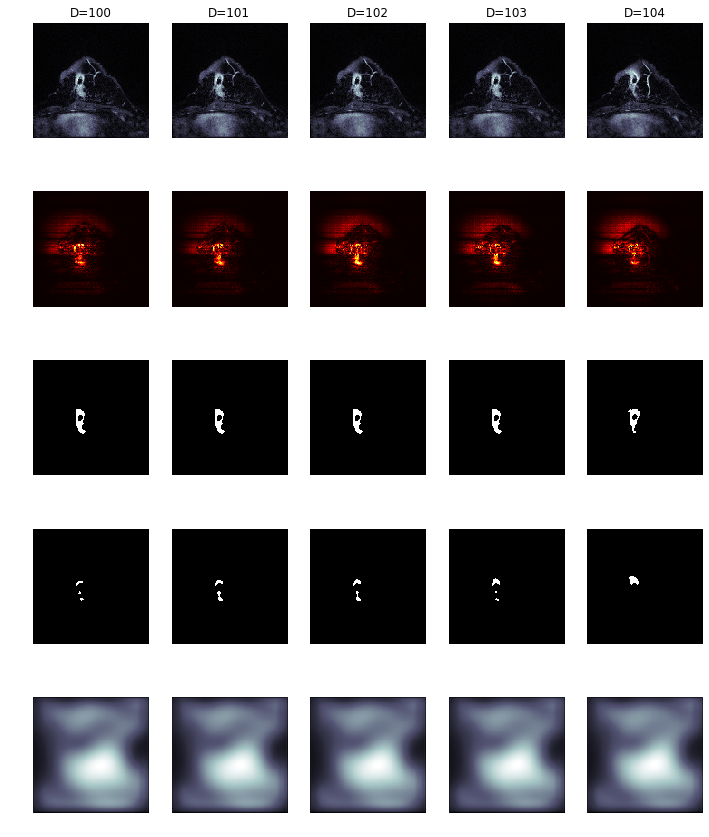

In [10]:
show_saliency_maps(X_train, y_train, model, loss_function, optimizer, config)

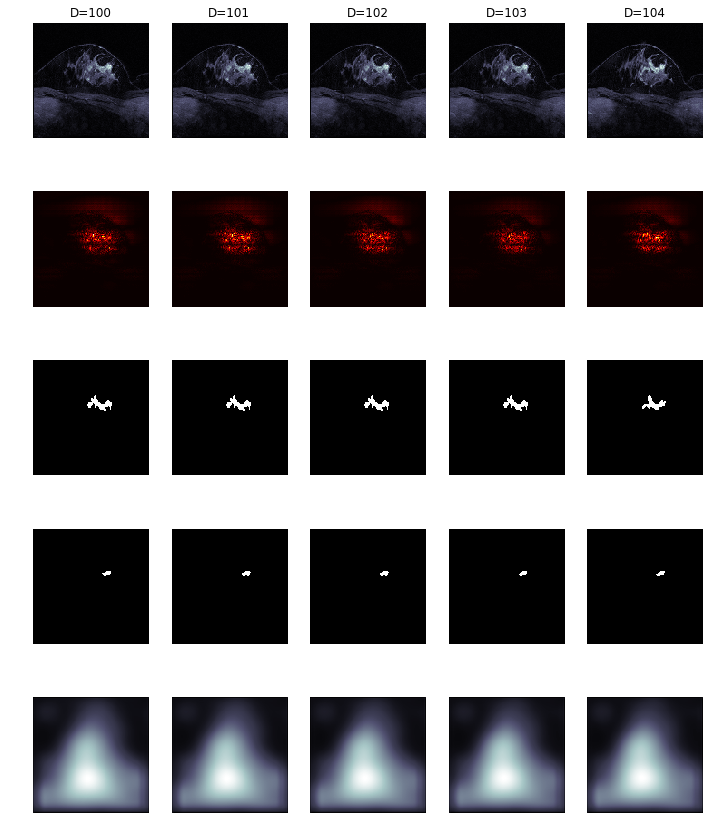

In [11]:
show_saliency_maps(X_val, y_val, model, loss_function, optimizer, config)